In [2]:
import pandas as pd
import uproot
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import crystalball
from scipy.optimize import curve_fit,Bounds
from scipy.integrate import simps
import zfit_physics as zphysics
import zfit
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import mplhep
import uncertainties 
from uncertainties import ufloat
import tensorflow as tf

plt.style.use('belle2')
#%jsroot on


%run /afs/desy.de/user/j/jipatel/MT/MC_fit/Files_After_Acceptance/Signal_Background_thesis_final/Function.ipynb

In [3]:
file_bkg_ele="/pnfs/desy.de/belle/local/user/msobotzi/p5prime/FilesAfterAcceptance/MC15/background/Bpeepi04Streams.root"
file_signal_ele="/pnfs/desy.de/belle/local/user/msobotzi/p5prime/FilesAfterAcceptance/MC15/signal/Bpeepi04Streams.root"


In [4]:
mc_ele_signal,mc_ele_only_signal,mc_ele_scf,mc_ele_bkg, mc_ele_signal_weight,mc_ele_only_signal_weight,mc_ele_scf_weight,mc_ele_bkg_weight = process_MC_data_combined(file_signal_ele, file_bkg_ele, 'ele', '521', 'pi0', 'ee', 1, 'rec521','PIDCorrectionAndAcceptanceWeight')


In [4]:
sum(mc_ele_signal_weight)

4.270499576548067

In [5]:
fit_and_integrate(mc_ele_signal, param_fl_start=0.5, param_s3_start=0.01, param_p5_start=0.02, floating=True)


InvalidArgumentError: All upper limits have to be larger than the lower limits and are given as (lower, upper). Maybe (upper, lower) was entered?
Condition x > y did not hold.
Indices of first 1 different values:
[[0 0]]
Corresponding x values:
[0.97727343]
Corresponding y values:
[0.97727343]
First 1 elements of x:
[0.97727343]
First 1 elements of y:
[0.97727343]

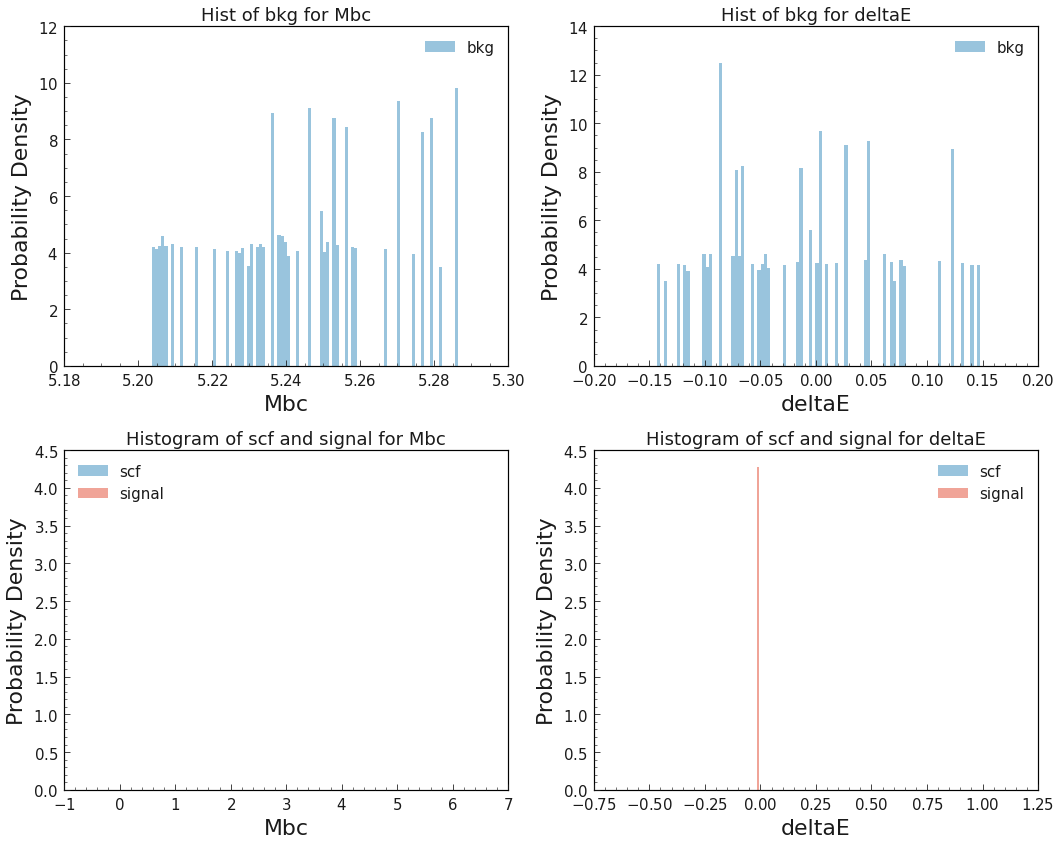

In [5]:
# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Mbc_bkg
plot_histogram(axs[0, 0], {"bkg":  mc_ele_bkg["Mbc"]},
               ["bkg"],
               {"bkg": mc_ele_bkg_weight},
               'Mbc', 'Probability Density', 'Hist of bkg for Mbc')

# deltaE_bkg
plot_histogram(axs[0, 1], {"bkg": mc_ele_bkg["deltaE"]},
               ["bkg"],
               {"bkg": mc_ele_bkg_weight},
               'deltaE', 'Probability Density', 'Hist of bkg for deltaE')

# Mbc_signal 
plot_histogram(axs[1, 0], {"scf": mc_ele_scf["Mbc"], 
                           "signal": mc_ele_only_signal["Mbc"]}, 
               ["scf", "signal"],
               {"scf": mc_ele_scf_weight, "signal": mc_ele_only_signal_weight}, 
               'Mbc', 'Probability Density', 'Histogram of scf and signal for Mbc')


# deltaE_signal
plot_histogram(axs[1, 1], {"scf": mc_ele_scf["deltaE"], 
                           "signal": mc_ele_only_signal["deltaE"]}, 
               ["scf", "signal"],
               {"scf": mc_ele_scf_weight, "signal": mc_ele_only_signal_weight},
               'deltaE', 'Probability Density', 'Histogram of scf and signal for deltaE')


# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

## Yield

In [6]:
# signal
Mbc_only_signal_cb_fixed = fit_fixed_unfixed_data('Mbc','ele', 'signal', mc_ele_only_signal["Mbc"], mc_ele_only_signal_weight,'cb',0)
deltaE_only_signal_cb_gauss_fixed= fit_fixed_unfixed_data('deltaE','ele', 'signal',mc_ele_only_signal["deltaE"], mc_ele_only_signal_weight,'cb_gauss',0)


#scf
Mbc_scf_argus_gauss_fixed= fit_fixed_unfixed_data('Mbc','ele', 'scf', mc_ele_scf["Mbc"], mc_ele_scf_weight,'argus_gauss',0)
deltaE_scf_poly_gauss_fixed= fit_fixed_unfixed_data('deltaE','ele', 'scf', mc_ele_scf["deltaE"], mc_ele_scf_weight,'poly_gauss',0)


#bkg
Mbc_bkg_argus_gauss_fixed= fit_fixed_unfixed_data('Mbc','ele', 'bkg',  mc_ele_bkg["Mbc"], mc_ele_bkg_weight,'argus_gauss',0)
deltaE_bkg_poly_gauss_fixed= fit_fixed_unfixed_data('deltaE','ele', 'bkg',  mc_ele_bkg["deltaE"], mc_ele_bkg_weight,'poly',0)



In [7]:
Signal_Mbc = mc_ele_only_signal["Mbc"]
Signal_deltaE = mc_ele_only_signal["deltaE"]

Background_Mbc = pd.concat([mc_ele_scf["Mbc"],mc_ele_bkg["Mbc"]])
Background_deltaE = pd.concat([mc_ele_scf["deltaE"],mc_ele_bkg["deltaE"]])

Signal_total = pd.concat([Signal_Mbc, Signal_deltaE], axis=1)
Background_total = pd.concat([Background_Mbc, Background_deltaE], axis=1)


Signal_weight = mc_ele_only_signal_weight
Background_weight = pd.concat([mc_ele_scf_weight,mc_ele_bkg_weight])


Mbc_signal_pdf,deltaE_signal_pdf,Mbc_background_pdf,deltaE_background_pdf,signal_extended, background_extended, total_model, result = fit_extended_model_scf(
    Mbc_only_signal_cb_fixed,Mbc_scf_argus_gauss_fixed,deltaE_only_signal_cb_gauss_fixed,deltaE_scf_poly_gauss_fixed,
    Mbc_bkg_argus_gauss_fixed,deltaE_bkg_poly_gauss_fixed,
    pd.concat([Signal_total, Background_total]),
    pd.concat([Signal_weight, Background_weight]),0.5,0.5,1000,1000
)

#result.hesse(name='hesse')
result.errors(name='errors')
print(result.params)
print(result.valid)


/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py:585: UserWarning: As `copy` is not yet properly implemented, this may fails (for ProductPDF for example?). Thiswill be fixed in the future.
  warnings.warn(


RuntimeError: Loss starts already with NaN, cannot minimize.

In [ ]:
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 10), gridspec_kw={'height_ratios': [3, 1]})

# Plot Mbc
plot_variable(axs[0, 0], axs[1, 0], "Mbc", mc_ele_signal,mc_ele_scf, mc_ele_bkg,mc_ele_signal_weight,mc_ele_scf_weight,
              mc_ele_bkg_weight,Mbc_signal_pdf, Mbc_background_pdf, "Signal Fit", "Bkg Fit","MC15(Sig_ri+bkg_rd)_Data", "M$_{bc}(GeV/c^2)$")

# Plot deltaE
plot_variable(axs[0, 1], axs[1, 1], "deltaE", mc_ele_signal,mc_ele_scf, mc_ele_bkg,mc_ele_signal_weight,mc_ele_scf_weight,
              mc_ele_bkg_weight,deltaE_signal_pdf, deltaE_background_pdf, "Signal Fit", "Bkg Fit","MC15(Sig_ri+bkg_rd)_Data","$\\Delta$E(GeV)")


# Adjust layout
plt.tight_layout()

# Show plot
#plt.savefig('Bppi0_q2reg1_decay_ee.pdf')
plt.show()
   


In [8]:
# signal
Mbc_only_signal_cb_fixed = fit_fixed('Mbc','ele', 'signal', mc_ele_only_signal["Mbc"], mc_ele_only_signal_weight,'cb',0)
deltaE_only_signal_cb_gauss_fixed= fit_fixed('deltaE','ele', 'signal',mc_ele_only_signal["deltaE"], mc_ele_only_signal_weight,'cb_gauss',0)

#bkg
Mbc_bkg_argus_gauss_fixed= fit_fixed('Mbc','ele', 'bkg',  mc_ele_bkg["Mbc"], mc_ele_bkg_weight,'argus_gauss',0)
deltaE_bkg_poly_gauss_fixed= fit_fixed('deltaE','ele', 'bkg',  mc_ele_bkg["deltaE"], mc_ele_bkg_weight,'poly',0)



In [9]:
Signal_Mbc = mc_ele_only_signal["Mbc"]
Signal_deltaE = mc_ele_only_signal["deltaE"]

Background_Mbc = pd.concat([mc_ele_scf["Mbc"],mc_ele_bkg["Mbc"]])
Background_deltaE = pd.concat([mc_ele_scf["deltaE"],mc_ele_bkg["deltaE"]])

Signal_total = pd.concat([Signal_Mbc, Signal_deltaE], axis=1)
Background_total = pd.concat([Background_Mbc, Background_deltaE], axis=1)


Signal_weight = mc_ele_only_signal_weight
Background_weight = pd.concat([mc_ele_scf_weight,mc_ele_bkg_weight])

print(sum(Signal_weight))
print(sum(Background_weight))


Mbc_signal_pdf,deltaE_signal_pdf,Mbc_background_pdf,deltaE_background_pdf,signal_extended, background_extended, total_model, result = fit_extended_model(
    Mbc_only_signal_cb_fixed,deltaE_only_signal_cb_gauss_fixed,Mbc_bkg_argus_gauss_fixed,deltaE_bkg_poly_gauss_fixed,
    pd.concat([Signal_total, Background_total]),
    pd.concat([Signal_weight, Background_weight]),100,1000
)

#result.hesse(name='hesse')
result.errors(name='errors')
print(result.params)
print(result.valid)


4.270499576548067
206.06368401360888


/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name                       value  (rounded)               errors    at limit
-----------------------  ------------------  -------------------  ----------
signal_yield_0.5181                0.548583  -    2.8   +    3.8       False
background_yield_0.5181             209.724  -     14   +     15       False
True


/tmp/ipykernel_1427883/1109665084.py:57: RuntimeWarning: divide by zero encountered in true_divide
  pulls = (n - y_total_fit_binned) / errors
/tmp/ipykernel_1427883/1109665084.py:57: RuntimeWarning: divide by zero encountered in true_divide
  pulls = (n - y_total_fit_binned) / errors


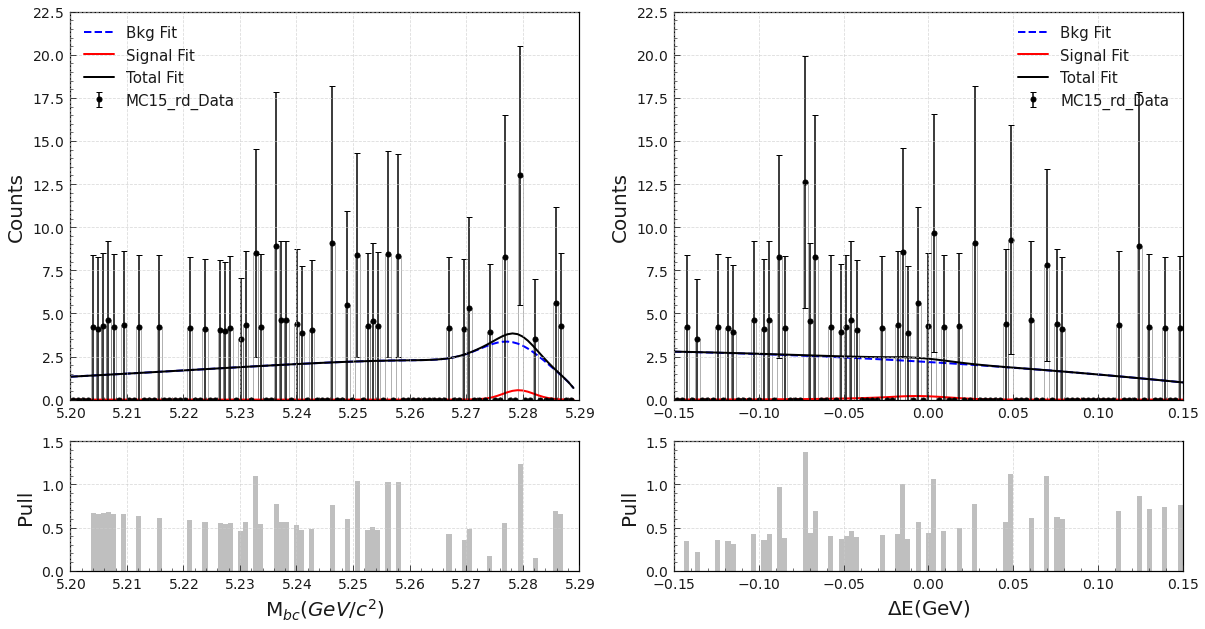

In [10]:
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 10), gridspec_kw={'height_ratios': [3, 1]})

# Plot Mbc
plot_variable(axs[0, 0], axs[1, 0], "Mbc", mc_ele_signal,mc_ele_scf, mc_ele_bkg,mc_ele_signal_weight,mc_ele_scf_weight,
              mc_ele_bkg_weight,Mbc_signal_pdf, Mbc_background_pdf, "Signal Fit", "Bkg Fit","MC15_rd_Data", "M$_{bc}(GeV/c^2)$")

# Plot deltaE
plot_variable(axs[0, 1], axs[1, 1], "deltaE", mc_ele_signal,mc_ele_scf, mc_ele_bkg,mc_ele_signal_weight,mc_ele_scf_weight,
              mc_ele_bkg_weight,deltaE_signal_pdf, deltaE_background_pdf, "Signal Fit", "Bkg Fit","MC15_rd_Data","$\\Delta$E(GeV)")


# Adjust layout
plt.tight_layout()

# Show plot
plt.savefig('Bppi0_q2reg1_decay_ee_rd.pdf')
plt.show()

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from uncertainties import ufloat  # Ensure you import this for uncertainty handling

# Assuming result is some fitting result object with parameters
signal_yield_value = result.params[signal_extended.get_yield()]['value']
signal_yield_errors = result.params[signal_extended.get_yield()]['errors']

# Calculate the symmetric uncertainty assuming you have upper and lower errors
signal_yield_error = (signal_yield_errors['upper'] - signal_yield_errors['lower']) / 2
signal_yield_with_uncertainty = ufloat(signal_yield_value, signal_yield_error)

normalization_factor = 0.368 * 4  # Fixed normalization factor

# Define your PDFs using whatever function you have for fitting
Mbc_only_signal_cb_fixed = fit_fixed('Mbc', 'ele', 'signal', mc_ele_only_signal["Mbc"], mc_ele_only_signal_weight, 'cb', 0)
deltaE_only_signal_cb_gauss_fixed = fit_fixed('deltaE', 'ele', 'signal', mc_ele_only_signal["deltaE"], mc_ele_only_signal_weight, 'cb_gauss', 0)
Mbc_bkg_argus_gauss_fixed = fit_fixed('Mbc', 'ele', 'bkg', mc_ele_bkg["Mbc"], mc_ele_bkg_weight, 'argus_gauss', 0)
deltaE_bkg_poly_fixed = fit_fixed('deltaE', 'ele', 'bkg', mc_ele_bkg["deltaE"], mc_ele_bkg_weight, 'poly', 0)

# Define luminosities to loop over
luminosities = [2, 5, 10, 25,40, 50,60, 80]

# Calculate the number of events per ab^-1
n_events_per_ab1 = signal_yield_value / normalization_factor

# Arrays to store results
signal_yields = []

for lumi in luminosities:
    # Calculate the number of events for this luminosity
    n_events = int(lumi * n_events_per_ab1)  # Convert directly to an integer
    
    # Sample signal events
    Mbc_samples_signal = Mbc_only_signal_cb_fixed.sample(n=n_events).numpy()
    deltaE_samples_signal = deltaE_only_signal_cb_gauss_fixed.sample(n=n_events).numpy()

    # Combine Mbc and deltaE into a single DataFrame for signal
    samples_signal_df = pd.DataFrame({'Mbc': Mbc_samples_signal.flatten(), 'deltaE': deltaE_samples_signal.flatten()})
    
    # Calculate scaled weights for signal
    scaled_signal_weights = pd.Series((Mbc_samples_signal.flatten() + deltaE_samples_signal.flatten()) * (lumi / 0.368))
    
    # Sample background events
    Mbc_samples_bkg = Mbc_bkg_argus_gauss_fixed.sample(n=n_events).numpy()  # Use n_events directly
    deltaE_samples_bkg = deltaE_bkg_poly_fixed.sample(n=n_events).numpy()
    
    # Combine Mbc and deltaE into a single DataFrame for background
    samples_bkg_df = pd.DataFrame({'Mbc': Mbc_samples_bkg.flatten(), 'deltaE': deltaE_samples_bkg.flatten()})
    
    # Calculate scaled weights for background
    scaled_bkg_weights = pd.Series((Mbc_samples_bkg.flatten() + deltaE_samples_bkg.flatten()) * (lumi / 0.368))
    
    # Concatenate signal and background dataframes
    combined_df = pd.concat([samples_signal_df, samples_bkg_df], axis=0)
    
    # Concatenate weights for signal and background
    combined_weights = pd.concat([scaled_signal_weights, scaled_bkg_weights], axis=0)
    
    # Perform the fit with the combined data and weights
    Mbc_signal_pdf, deltaE_signal_pdf, Mbc_background_pdf, deltaE_background_pdf, signal_extended, background_extended, total_model, result = fit_extended_model(
        Mbc_only_signal_cb_fixed, deltaE_only_signal_cb_gauss_fixed, Mbc_bkg_argus_gauss_fixed, deltaE_bkg_poly_fixed,
        combined_df, combined_weights, 100, 100
    )

    # Optionally calculate errors or perform other fitting operations
    result.errors(name='errors')
    print(result.params)
    print(result.valid)

    # Retrieve and store the signal yield and its error
    signal_yield = result.params[signal_extended.get_yield()]['value']
    signal_yield_errors = result.params[signal_extended.get_yield()]['errors']
    signal_yield_error = (signal_yield_errors['upper'] - signal_yield_errors['lower']) / 2

    # Store the signal yield and error as a tuple in the list
    signal_yields.append((lumi, signal_yield, signal_yield_error))

# Convert the list to a DataFrame with columns for luminosity, signal yield, and its error
events_per_luminosity = pd.DataFrame(signal_yields, columns=['luminosity', 'signal_yield', 'signal_yield_error'])

# Extract data for plotting
luminosities = events_per_luminosity['luminosity']
signal_yields = events_per_luminosity['signal_yield']
signal_yield_errors = events_per_luminosity['signal_yield_error']

print(luminosities)
print(signal_yields)
print(signal_yield_errors)

# Plot the Signal Yield vs. Luminosity
plt.figure(figsize=(12, 8))
plt.errorbar(luminosities, signal_yields, yerr=signal_yield_errors, fmt='o', capsize=10, label='Signal Yield', color='darkorange')

#plt.title('Signal Yield vs. Integrated Luminosity', fontsize=20, fontweight='bold')
plt.xlabel('Integrated Luminosity (ab$^{-1}$)', fontsize=20)
plt.yscale("log")
plt.ylabel('Signal Yield', fontsize=20)

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=20)

plt.xlim(0, 85)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.savefig("Bppi0_q2reg1_decay_ee_Signal_Yield_Integrated_Luminosity.pdf", format='pdf')  # Corrected this line
plt.show()


2024-09-12 23:15:42.411236: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at stateful_random_ops.cc:327 : INVALID_ARGUMENT: For the Philox algorithm, the size of state must be at least 3; got 0


InvalidArgumentError: Graph execution error:

Detected at node 'stateful_uniform/RngReadAndSkip' defined at (most recent call last):
    File "/cvmfs/belle.cern.ch/el9/externals/v02-00-02b/Linux_x86_64/common/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/cvmfs/belle.cern.ch/el9/externals/v02-00-02b/Linux_x86_64/common/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/cvmfs/belle.cern.ch/el9/externals/v02-00-02b/Linux_x86_64/common/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/cvmfs/belle.cern.ch/el9/externals/v02-00-02b/Linux_x86_64/common/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/cvmfs/belle.cern.ch/el9/externals/v02-00-02b/Linux_x86_64/common/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/cvmfs/belle.cern.ch/el9/externals/v02-00-02b/Linux_x86_64/common/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/cvmfs/belle.cern.ch/el9/externals/v02-00-02b/Linux_x86_64/common/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/cvmfs/belle.cern.ch/el9/externals/v02-00-02b/Linux_x86_64/common/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/cvmfs/belle.cern.ch/el9/externals/v02-00-02b/Linux_x86_64/common/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/cvmfs/belle.cern.ch/el9/externals/v02-00-02b/Linux_x86_64/common/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "/cvmfs/belle.cern.ch/el9/externals/v02-00-02b/Linux_x86_64/common/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "/cvmfs/belle.cern.ch/el9/externals/v02-00-02b/Linux_x86_64/common/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 353, in dispatch_shell
      await result
    File "/cvmfs/belle.cern.ch/el9/externals/v02-00-02b/Linux_x86_64/common/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "/cvmfs/belle.cern.ch/el9/externals/v02-00-02b/Linux_x86_64/common/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/cvmfs/belle.cern.ch/el9/externals/v02-00-02b/Linux_x86_64/common/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/cvmfs/belle.cern.ch/el9/externals/v02-00-02b/Linux_x86_64/common/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2914, in run_cell
      result = self._run_cell(
    File "/cvmfs/belle.cern.ch/el9/externals/v02-00-02b/Linux_x86_64/common/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "/cvmfs/belle.cern.ch/el9/externals/v02-00-02b/Linux_x86_64/common/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "/cvmfs/belle.cern.ch/el9/externals/v02-00-02b/Linux_x86_64/common/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/cvmfs/belle.cern.ch/el9/externals/v02-00-02b/Linux_x86_64/common/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/cvmfs/belle.cern.ch/el9/externals/v02-00-02b/Linux_x86_64/common/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_1427883/2749817280.py", line 38, in <module>
      deltaE_samples_signal = deltaE_only_signal_cb_gauss_fixed.sample(n=n_events).numpy()
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basemodel.py", line 1243, in sample
      sample=run_tf(n=n, limits=limits, x=x), obs=new_obs
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basemodel.py", line 1234, in run_tf
      sample = self._single_hook_sample(n=n, limits=limits, x=x)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/z/zextension.py", line 298, in concrete_func
      result = func_to_run(*args, **kwargs)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basemodel.py", line 1251, in _single_hook_sample
      return self._hook_sample(n=n, limits=limits)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py", line 661, in _hook_sample
      samples = super()._hook_sample(limits=limits, n=n)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basemodel.py", line 1254, in _hook_sample
      return self._norm_sample(n=n, limits=limits)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basemodel.py", line 1258, in _norm_sample
      return self._limits_sample(n=n, limits=limits)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basemodel.py", line 1262, in _limits_sample
      return self._call_sample(n=n, limits=limits)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basemodel.py", line 1290, in _call_sample
      return self._sample(n=n, limits=limits)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/space.py", line 3215, in new_func
      return func(*args, **kwargs)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/models/functor.py", line 270, in _sample
      sub_sample = pdf.sample(n=n_sample, limits=limits)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basemodel.py", line 1243, in sample
      sample=run_tf(n=n, limits=limits, x=x), obs=new_obs
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basemodel.py", line 1234, in run_tf
      sample = self._single_hook_sample(n=n, limits=limits, x=x)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/z/zextension.py", line 247, in concrete_func
      return func(*args, **kwargs)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basemodel.py", line 1251, in _single_hook_sample
      return self._hook_sample(n=n, limits=limits)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py", line 661, in _hook_sample
      samples = super()._hook_sample(limits=limits, n=n)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basemodel.py", line 1254, in _hook_sample
      return self._norm_sample(n=n, limits=limits)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basemodel.py", line 1258, in _norm_sample
      return self._limits_sample(n=n, limits=limits)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basemodel.py", line 1262, in _limits_sample
      return self._call_sample(n=n, limits=limits)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basemodel.py", line 1292, in _call_sample
      return self._analytic_sample(n=n, limits=limits)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/models/dist_tfp.py", line 129, in _analytic_sample
      return tfd_analytic_sample(n=n, dist=self.distribution, limits=limits)
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/models/dist_tfp.py", line 56, in tfd_analytic_sample
      prob_sample = z.random.uniform(
    File "/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/z/random.py", line 136, in uniform
      return get_prng().uniform(
Node: 'stateful_uniform/RngReadAndSkip'
For the Philox algorithm, the size of state must be at least 3; got 0
	 [[{{node stateful_uniform/RngReadAndSkip}}]] [Op:__inference__single_hook_sample_30384]